<a href="https://colab.research.google.com/github/IImbryk/NMA_MindBigData/blob/work/mnist_for_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Work plan:\
Step 1. Our task. Data description \
Step 2. Load datasets\
Step 3. \


# 1. Our task. Data description

*Predicting the number that a person sees according to EEG data* \
[dataset](http://www.mindbigdata.com/opendb/)

* [id]: a numeric, only for reference purposes.

* [event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

* [device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

* [channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
MindWave	"FP1"
EPOC	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
Muse	"TP9,"FP1","FP2", "TP10"
Insight	"AF3,"AF4","T7","T8","PZ" 

* [code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

* [size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

* [data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

from google.colab import drive


# Imports
import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange

In [4]:
drive.mount('/content/drive', force_remount=True)
path_dir = '/content/drive/MyDrive/Data Brain MNIST' 

path_dir_test = '/content/drive/MyDrive/Data Science/Neuromatch Academy/input_test'

Mounted at /content/drive


In [5]:
file_name =  ['/MindBigData-EP-v1.0/EP1.01.txt',
              '/MindBigData-IN-v1.06/IN.txt',
              '/MindBigData-MU-v1.0/MU.txt',
              '/MindBigData-MW-v1.0/MW.txt']

In [6]:
import torch
from torch import nn

a = torch.rand(400,1,27)
m = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3) 
out = m(a)
print(out.size())
print(m)

torch.Size([400, 1, 25])
Conv1d(1, 1, kernel_size=(3,), stride=(1,))


<a id='step_2'></a>
# 2. Load data 


In [7]:
#load data from 4 files
data_EP1 = pd.read_csv(path_dir+file_name[0], sep="\t", header=None)
data_IN = pd.read_csv(path_dir+file_name[1], sep="\t", header=None)
data_MU = pd.read_csv(path_dir+file_name[2], sep="\t", header=None)
data_MW = pd.read_csv(path_dir+file_name[3], sep="\t", header=None) #, nrows=99)
df = pd.concat([data_EP1, data_IN, data_MU, data_MW], ignore_index=True)
#data = data_2.copy(deep=True)

In [8]:
# переименовать столбцы в соотв. с http://www.mindbigdata.com/opendb/
columns_rename = {0: 'id', 1: 'event',
                 2: 'device', 3:'channel',
                 4: 'code', 5: 'size', 6:'data'}

In [9]:
def rename_columns(data):
  data = data.rename(columns=columns_rename)
  return data

In [48]:
df = rename_columns(df)
# data_MW = rename_columns(data_MW)
data_EP1 = rename_columns(data_EP1)
# data_MU = rename_columns(data_MU)
# data_IN = rename_columns(data_IN)

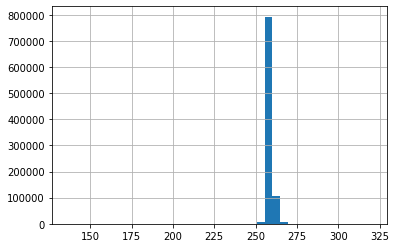

In [38]:
data_EP1['size'].hist(bins=40)

In [39]:
data_EP1

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"4395.384615,4382.564102,4377.435897,4387.17948..."
1,67636,67635,EP,F7,6,260,"4489.230769,4475.384615,4474.358974,4486.66666..."
2,67637,67635,EP,F3,6,260,"4538.461538,4528.717948,4524.615384,4526.15384..."
3,67638,67635,EP,FC5,6,260,"4207.692307,4205.641025,4200.512820,4194.35897..."
4,67639,67635,EP,T7,6,260,"4497.948717,4498.461538,4494.871794,4497.94871..."
...,...,...,...,...,...,...,...
910471,978106,132668,EP,T8,-1,256,"4528.205128,4526.153846,4525.128205,4516.41025..."
910472,978107,132668,EP,FC6,-1,256,"4230.769230,4228.205128,4237.435897,4234.87179..."
910473,978108,132668,EP,F4,-1,256,"4576.410256,4576.410256,4581.538461,4580.00000..."
910474,978109,132668,EP,F8,-1,256,"3949.230770,3947.179488,3946.666667,3944.10256..."


In [ ]:
def merge_data(df1, df2):
  # data['event'].value_counts()
  """
  column EVENT don't intersection in 4 files.
  """
  df3 = df1.merge(df2, left_on="event", right_on="event", how="inner")
  print(df3["event"])

In [11]:
min_len = df['size'].min()
max_len = df['size'].max()
print(max_len, min_len)
columns_name = ['eeg'+str(x) for x in range(max_len)]

1024 40


In [ ]:
# mat = np.matrix(data[6][0].split(",")[0:max_len])
# for i in range(1, len(data)):
  # mat = np.append(mat,np.matrix(data[6][i].split(",")[0:max_len]), axis=0)
# df_new = pd.concat([data, pd.DataFrame(mat, columns=columns_name)], axis=1)

In [ ]:
###Polina 
# list_of_names = ['id', 'event', 'device','channel', 'code', 'size', 'data']
# df= pd.read_csv('gdrive/My Drive/Data Brain MNIST/MindBigData-MW-v1.0/MW.txt', delimiter = "\t", names = list_of_names)
# for i in range(len(df['data'])):
  # df['data'][i] = df['data'][i].split(',') ###uncomment for the first time only 
  # for j in range(len(df['data'][i])):
    # df['data'][i][j] = int(df['data'][i][j])

In [12]:
def parse_str(data_inp, max_len):
  data = data_inp.copy(deep=True)
  for i in range(0, len(data)):
    eeg = list(map(int, data['data'][i].split(',')))
    zero_add = [0] * (max_len - len(eeg))
    data['data'][i] = eeg + zero_add
  return data

In [52]:
def parse_str_(data_inp, max_len):
  data = data_inp.copy(deep=True)
  for i in range(0, len(data)):
    eeg = list(map(float, data['data'][i].split(',')))
    data['data'][i] = eeg
  return data

In [ ]:
#df_parse= parse_str(df, df['size'].max())

ValueError: ignored

In [13]:
data_MW_copy = parse_str(data_MW, data_MW['size'].max())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
from scipy.interpolate import interp1d
from scipy import arange
import numpy as np
x = arange(0,len(data_EP1['data'][0]))
f=interp1d(x, data_EP1['data'][0])
x=arange(7050, 12000)
y=f(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.


ValueError: ignored

In [55]:
data_EP1_copy = parse_str_(data_EP1[0:100], 256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [72]:
data_EP1_copy.query('code==7')

,id,event,device,channel,code,size,data
14,67649,67636,EP,AF3,7,260,"[4385.641025, 4381.538461, 4386.666666, 4383.5..."
15,67650,67636,EP,F7,7,260,"[4482.564102, 4477.435897, 4484.102564, 4484.6..."
16,67651,67636,EP,F3,7,260,"[4522.564102, 4522.051282, 4527.179487, 4521.0..."
17,67652,67636,EP,FC5,7,260,"[4217.435897, 4221.538461, 4228.717948, 4224.6..."
18,67653,67636,EP,T7,7,260,"[4498.974358, 4500.0, 4499.487179, 4494.871794..."
19,67654,67636,EP,P7,7,260,"[4194.358974, 4192.307692, 4191.794871, 4188.2..."
20,67655,67636,EP,O1,7,260,"[4396.410256, 4388.717948, 4390.76923, 4395.89..."
21,67656,67636,EP,O2,7,260,"[4208.717948, 4197.435897, 4198.461538, 4203.0..."
22,67657,67636,EP,P8,7,260,"[4228.205128, 4214.871794, 4211.282051, 4213.8..."
23,67658,67636,EP,T8,7,260,"[4507.692307, 4492.307692, 4484.102564, 4492.8..."


In [91]:
np.array(data_EP1_copy.query('code==7')['channel'])[0]

'AF3'

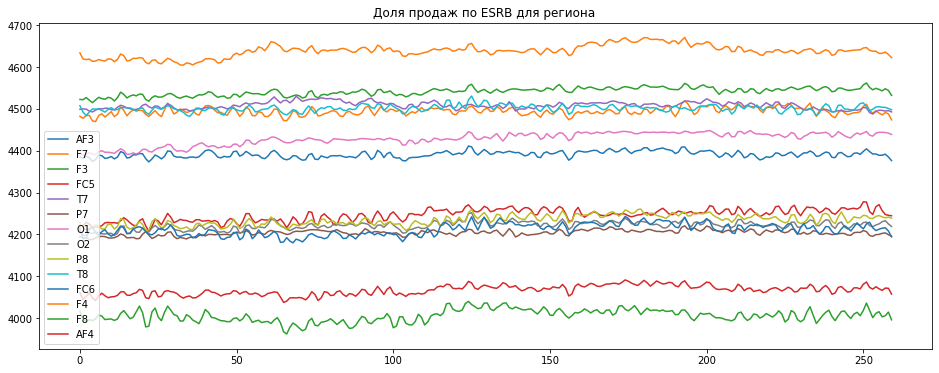

In [94]:
plt.figure(figsize=(16,6))
plt.title('Доля продаж по ESRB для региона ')
for i in data_EP1_copy.query('code==7').index:
  plt.plot(data_EP1_copy['data'][i], label=data_EP1_copy['channel'][i])
plt.legend()

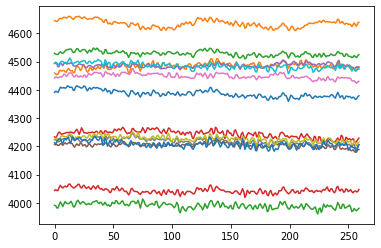

In [77]:
plt.figure()
for i in data_EP1_copy.query('code==8').index:
  plt.plot(data_EP1_copy['data'][i])

In [71]:
data_EP1_copy['code'].value_counts()

9    28
0    28
6    16
8    14
7    14
Name: code, dtype: int64

In [ ]:
# # фильтрация - пока не нужна!
# from scipy.interpolate import Rbf

# y = data['data'][1]

# rbf = Rbf(range(0,max_len), y, function = 'quintic', smooth = 10)

# xnew = np.linspace(0, max_len, num = 100, endpoint = True)
# ynew = rbf(xnew)

# plt.figure()
# plt.plot(y)
# plt.plot(xnew, ynew, 'r')
# plt.show()

# Train linear model

In [ ]:
class LNNet(nn.Module):
  """A Linear Neural Net with one hidden layer
  """

  def __init__(self, in_dim, hid_dim, out_dim):
    """
    Args:
      in_dim (int): input dimension
      out_dim (int): ouput dimension
      hid_dim (int): hidden dimension
    """
    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)

  def forward(self, x):
    """
    Args:
      x (torch.Tensor): input tensor
    """
    hid = self.in_hid(x)  # hidden activity
    out = self.hid_out(hid)  # output (prediction)
    return out, hid


In [ ]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """Training function

  Args:
    model (torch nn.Module): the neural network
    inputs (torch.Tensor): features (input) with shape `[batch_size, input_dim]`
    targets (torch.Tensor): targets (labels) with shape `[batch_size, output_dim]`
    n_epochs (int): number of training epochs (iterations)
    lr (float): learning rate
    illusory_i (int): index of illusory feature

  Returns:
    np.ndarray: record (evolution) of training loss
    np.ndarray: record (evolution) of singular values (dynamic modes)
    np.ndarray: record (evolution) of representational similarity matrices
    np.ndarray: record of network prediction for the last feature
  """
  in_dim = inputs.size(1)
  losses = np.zeros(n_epochs)  # loss records

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)

    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()

  return losses

In [ ]:
def plot_loss(loss_array, title="Training loss (Mean Squared Error)", c="r"):
  plt.figure(figsize=(10, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()

In [ ]:
# split into train test sets
y = torch.tensor([data_MW_copy['code']]).float().T
X = torch.tensor(data_MW_copy['data']).float() # data_EP1.drop(columns=['id', 'event', 'code'], axis=1) 

label_tensor = torch.tensor(data_MW_copy['data']).float()
feature_tensor = torch.tensor([data_MW_copy['code']]).float().T


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# train_set_orig, test_set_orig= torch.utils.data.random_split(X, [len(X)-10000, 10000])

# BATCH_SIZE = 1
# # Create the corresponding DataLoaders for training and test
# g_seed = torch.Generator()

# train_loader = torch.utils.data.DataLoader(train_set_orig,
#                                            shuffle=True,
#                                            batch_size=BATCH_SIZE,
#                                            num_workers=2,
#                                            generator=g_seed)
# test_loader = torch.utils.data.DataLoader(test_set_orig,
#                                           batch_size=256,
#                                           num_workers=2,
#                                           generator=g_seed)

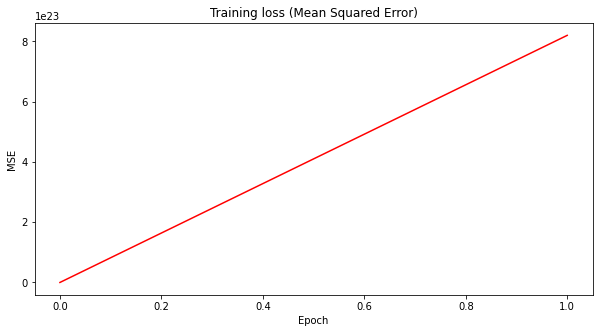

In [ ]:
lr = 10.0 # learning rate
gamma = 1e-12  # initialization scale
n_epochs = 250  # number of epochs
dim_input = X_train.size(1)
dim_hidden = 1024# 1017 # hidden neurons
dim_output = y_train.size(1)  # output dimension = `feature_tensor.size(1)`

# model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# weights re-initialization
# initializer_(dlnn_model, gamma)
# training
losses = train(dlnn_model,
                  X_train,
                  y_train,
                  n_epochs=n_epochs,
                  lr=lr)

# plotting
plot_loss(losses)

# MNE Lib (https://mne.tools/)

try this example:https://www.kaggle.com/broach/getting-started-with-mne-python-and-subs-1-to-24/data?scriptVersionId=13939515&select=time.csv

doc: https://github.com/mne-tools/mne-python

In [ ]:
!pip install -U mne

In [ ]:
import mne

In [ ]:
import numpy as np
import pandas as pd
from mne import EpochsArray
from mne.channels import make_standard_montage #read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
#from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [ ]:
col_names = pd.read_csv(path_dir_test+'/columnLabels.csv')

In [ ]:
ch_names = list(col_names.columns[4:])
#ch_names = montage.ch_names
# define the channel type, where the first 64 are EEG, next 4 are EOG, then Nose,
#and finally right mastoid (EEG)
ch_type = ['eeg']*64 + ['eog']*4 + ['misc'] + ['eeg']
    
# The sampling rate of the recording
sfreq = 1024  # in Hertz (samples per second)

#print(ch_names)
# read EEG standard montage from mne
montage = make_standard_montage('standard_1005')

# Initialize required fields
info = create_info(ch_names=ch_names, sfreq=20, ch_types=ch_type)
#for debugging:
fname = path_dir_test + '/1.csv'

In [ ]:
#define the function:
def creat_mne_epoch_object(fname, info):
    """Create a mne epoch instance from csv file"""
    # Add some more information
    info['description'] = 'dataset from ' + fname
    
    # Trials were cut from -1.5 to 1.5 seconds
    tmin = -1.5

    # Read EEG file
    data = pd.read_csv(fname, header=None)
    #print(data)
    #and convert it to numpy array:
    npdata = np.array(data)
    
    #the first 4 columns of the data frame are the
    #subject number... subNumber = npdata[:,0]
    #trial number... trialNumber = npdata[:,1]
    #condition number... conditions = npdata[:,2]
    #and sample number (within a trial)... sampleNumber = npdata[:,3]
    
    #sample 1537 is time 0, use that for the event 
    onsets = np.array(np.where(npdata[:,3]==1537))
    conditions = npdata[npdata[:,3]==1537,2]



    #use these to make an events array for mne (middle column are zeros):
    events = np.squeeze(np.dstack((onsets.flatten(), np.zeros(conditions.shape),conditions)))
    #print(events)

    #now we just need EEGdata in a 3D shape (n_epochs, n_channels, n_samples)
    EEGdata = npdata.reshape(len(conditions),3072,74)
    #remove the first 4 columns (non-eeg, described above):
    EEGdata = EEGdata[:,:,4:]
    EEGdata = np.swapaxes(EEGdata,1,2)
    
    #create labels for the conditions, 1, 2, and 3:
    event_id = dict(button_tone=1, playback_tone=2, button_alone=3)
    
    # create raw object 
    custom_epochs = EpochsArray(EEGdata, info=info, events=events.astype('int'), tmin=tmin, event_id=event_id)
    return custom_epochs

In [ ]:
custom_epochs = creat_mne_epoch_object(fname, info)

[[1.53600e+03 0.00000e+00 1.00000e+00]
 [4.60800e+03 0.00000e+00 1.00000e+00]
 [7.68000e+03 0.00000e+00 2.00000e+00]
 [1.07520e+04 0.00000e+00 3.00000e+00]
 [1.38240e+04 0.00000e+00 1.00000e+00]
 [1.68960e+04 0.00000e+00 2.00000e+00]
 [1.99680e+04 0.00000e+00 1.00000e+00]
 [2.30400e+04 0.00000e+00 2.00000e+00]
 [2.61120e+04 0.00000e+00 3.00000e+00]
 [2.91840e+04 0.00000e+00 1.00000e+00]
 [3.22560e+04 0.00000e+00 2.00000e+00]
 [3.53280e+04 0.00000e+00 3.00000e+00]
 [3.84000e+04 0.00000e+00 1.00000e+00]
 [4.14720e+04 0.00000e+00 2.00000e+00]
 [4.45440e+04 0.00000e+00 3.00000e+00]
 [4.76160e+04 0.00000e+00 1.00000e+00]
 [5.06880e+04 0.00000e+00 2.00000e+00]
 [5.37600e+04 0.00000e+00 3.00000e+00]
 [5.68320e+04 0.00000e+00 1.00000e+00]
 [5.99040e+04 0.00000e+00 2.00000e+00]
 [6.29760e+04 0.00000e+00 3.00000e+00]
 [6.60480e+04 0.00000e+00 1.00000e+00]
 [6.91200e+04 0.00000e+00 2.00000e+00]
 [7.21920e+04 0.00000e+00 3.00000e+00]
 [7.52640e+04 0.00000e+00 1.00000e+00]
 [7.83360e+04 0.00000e+00

In [ ]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])

In [ ]:
picks = pick_types(custom_epochs.info,eeg=True)
    
    #could not filter epochs with mne 0.13, upgraded to 0.15 to get this to work:
    # Filter data for alpha frequency and beta band
    # Note that MNE implements a zero phase (filtfilt) filer
custom_epochs.filter(2,6, picks=picks, method='iir', n_jobs=-1, verbose=False)
    

Number of events,289
Events,button_alone: 95button_tone: 100playback_tone: 94
Time range,-1.500 – 152.050 sec
Baseline,off


In [ ]:
pick_types(custom_epochs.info,eeg=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 69])

# CNN

In [14]:
# split into train test sets
y = torch.tensor([data_MW_copy['code']]).float().T
X = torch.tensor(data_MW_copy['data']).float() # data_EP1.drop(columns=['id', 'event', 'code'], axis=1) 


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
class CNN_net(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """
  def __init__(self, in_dim, out_dim, kernel_size=3, padding=0):
    super().__init__()

    # in_channels (int): Number of channels in the input
    # out_channels (int): Number of channels produced by the convolution
    # kernel_size (int or tuple): Size of the convolving kernel
    # padding (int or tuple, optional): Zero-padding added to both sides of
    #     the input. Default: 0

    self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, \
                           padding=padding)
    
    self.fc1 = nn.Linear(in_dim-kernel_size+1,10)
    # self.fc1 = nn.Linear(in_dim-kernel_size+1,1)
    self.pool = nn.MaxPool1d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)

    # x = self.pool(x)
    # x = torch.flatten(x,1)
    # x = self.fc1(x)
    # x = F.relu(x)
    x = self.fc1(x)
    return x

In [19]:
lr = 0.001 # learning rate
n_epochs = 25
dim_input = X_train.size(1)
dim_output = y_train.size(1)
losses = np.zeros(n_epochs)  # loss records

model = CNN_net(dim_input, dim_output)

criterion = nn.MSELoss()# nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_loss, validation_loss = [], []
train_acc, validation_acc = [], []


for i in range(n_epochs):
  for ind in range(0, len(X_train)):
    optimizer.zero_grad()
    input = X_train[ind] #torch.unsqueeze(X_train,1)
    predictions = model(input.unsqueeze(0).unsqueeze(0))
    _, out = torch.max(predictions.squeeze(0), 1)# out = torch.argmax(predictions).to(torch.float32)
    out = out.to(torch.float32)
    loss = criterion(out, y_train[ind])
    loss.requires_grad_(True)
    loss.backward()
    optimizer.step()
    losses[i] = loss.item()

In [18]:
epochs = 20
batch_size = 4

dim_input = X_train.size(1)
dim_output = y_train.size(1)
losses = np.zeros(n_epochs)  # loss records

model = CNN_net(dim_input, dim_output)

criterion = nn.MSELoss()# nn.CrossEntropyLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

with tqdm(range(epochs), unit='epoch') as tepochs:
  tepochs.set_description('Training')
  for epoch in tepochs:
     for i in range(0, len(X_train), batch_size):
       X_train[i:i+batch_size]
      # model.train()
      # keeps track of the running loss
      # running_loss = 0.
      # correct, total = 0, 0
      # for data, target in train_loader:
        # data, target = data.to(device), target.to(device)

In [32]:
## Testing
correct = 0
total = len(X_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for i in range(0, X_test.size(0)):

    out = model(X_test[i].unsqueeze(0).unsqueeze(0))
    # print(out)
    _, pred = torch.max(out.squeeze(0), 1)
    # print(pred)
    pred = pred.to(torch.float32)


    correct += torch.sum((pred == y_test[i]))


print(f'Test accuracy: {correct/total * 100:.2f}%')

Test accuracy: 7.90%


In [ ]:
torch.round(out.data.squeeze(1).squeeze(1))

tensor([3.])

In [ ]:
_,predict = torch.max(out.data,1)

In [ ]:
predict

tensor([[0]])

In [ ]:
conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3)
pool = nn.MaxPool1d(2)    

In [ ]:
conv1.weight

Parameter containing:
tensor([[[-0.0021,  0.4037,  0.3169]]], requires_grad=True)

In [ ]:
conv1(input).size()

torch.Size([50726, 1, 1022])

In [ ]:
pool(conv1(input)).size()

torch.Size([50726, 1, 511])

In [ ]:
input

tensor([[[  81.,   42.,   21.,  ...,  -36.,  -43.,  -52.]],

        [[ -45., -110., -162.,  ...,  -18.,  -51.,  -36.]],

        [[ -38.,  -49.,  -29.,  ...,   64.,  150.,  203.]],

        ...,

        [[  80.,   65.,   40.,  ...,    0.,    0.,    0.]],

        [[  12.,   12.,   20.,  ...,    0.,    0.,    0.]],

        [[ -10.,   -2.,    1.,  ...,    0.,    0.,    0.]]])

In [ ]:
X_train

tensor([[  81.,   42.,   21.,  ...,  -36.,  -43.,  -52.],
        [ -45., -110., -162.,  ...,  -18.,  -51.,  -36.],
        [ -38.,  -49.,  -29.,  ...,   64.,  150.,  203.],
        ...,
        [  80.,   65.,   40.,  ...,    0.,    0.,    0.],
        [  12.,   12.,   20.,  ...,    0.,    0.,    0.],
        [ -10.,   -2.,    1.,  ...,    0.,    0.,    0.]])

In [ ]:
X

tensor([[  38.,   48.,   51.,  ...,    0.,    0.,    0.],
        [  83.,   74.,   65.,  ...,    0.,    0.,    0.],
        [  19.,   10.,   -2.,  ...,    0.,    0.,    0.],
        ...,
        [  96.,  163.,  208.,  ..., -109., -101.,  -61.],
        [ -30.,    4.,   53.,  ...,  103.,   69.,   51.],
        [  41.,   27.,   41.,  ...,   36.,   64.,   76.]])

In [ ]:
data_MW_copy['data']

0        [38, 48, 51, 44, 48, 56, 56, 41, 20, -3, -9, -...
1        [83, 74, 65, 65, 66, 55, 43, 25, 18, 20, 26, 3...
2        [19, 10, -2, -9, -5, 3, 8, 7, 8, 2, -10, -21, ...
3        [17, 29, 36, 26, 21, 17, 17, 13, 17, 21, 25, 2...
4        [77, 74, 69, 70, 76, 75, 76, 75, 67, 66, 76, 9...
                               ...                        
67630    [138, 135, 123, 96, 59, 38, 11, 16, 44, 67, 70...
67631    [4, 5, -7, -12, -11, -17, 2, 52, 73, 55, 12, -...
67632    [96, 163, 208, 179, 129, 114, 140, 155, 108, 5...
67633    [-30, 4, 53, 85, 84, 72, 80, 85, 65, 23, -26, ...
67634    [41, 27, 41, 76, 88, 80, 83, 76, 60, 72, 112, ...
Name: data, Length: 67635, dtype: object